In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../../../BayesFlow')))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial
import pickle

import tensorflow as tf

In [2]:
from bayesflow import benchmarks
from bayesflow.amortizers import AmortizedPosterior, AmortizedLikelihood, AmortizedPosteriorLikelihood
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import plot_sbc_ecdf, plot_recovery, plot_posterior_2d, plot_losses, plot_latent_space_2d

/Users/marvin/projects/BayesFlow/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
benchmark_name = 'bernoulli_glm_raw'
benchmark = benchmarks.Benchmark(benchmark_name)

INFO:root:Performing 2 pilot runs with the bernoulli_glm_raw model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 10)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100, 10)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


# Amortizer and Trainer

In [4]:
SETTINGS_POST = {
    't_args': {
        'dense_args': dict(units=32, kernel_initializer='glorot_uniform', activation='elu'),
        'n_dense': 2,
        'dropout': True,
        'dropout_prob': 0.05
    },
    's_args': {
        'dense_args': dict(units=32, kernel_initializer='glorot_uniform', activation='elu'),
        'n_dense': 2,
        'dropout': True,
        'dropout_prob': 0.05
    }
}

SETTINGS_LIK = {
    't_args': {
        'dense_args': dict(units=64, kernel_initializer='glorot_uniform', activation='tanh'),
        'n_dense': 2,
        'dropout': True,
        'dropout_prob': 0.01
    },
    's_args': {
        'dense_args': dict(units=64, kernel_initializer='glorot_uniform', activation='tanh'),
        'n_dense': 2,
        'dropout': True,
        'dropout_prob': 0.01
    }
}

summary_net = InvariantNetwork(20)

amortizer = AmortizedPosteriorLikelihood(
    AmortizedPosterior(
        InvertibleNetwork(num_params=10, num_coupling_layers=8, coupling_net_settings=SETTINGS_POST),
        summary_net),
    AmortizedLikelihood(
        InvertibleNetwork(num_params=2, num_coupling_layers=8, coupling_net_settings=SETTINGS_LIK, use_soft_flow=True))
)

In [5]:
trainer = Trainer(
    amortizer=amortizer,
    default_lr=5e-4,
    generative_model=benchmark.generative_model,
    configurator=partial(benchmark.configurator, as_summary_condition=True),
    checkpoint_path=f'checkpoints/{benchmark_name}',
    memory=False   
)

INFO:root:Loaded loss history from checkpoints/bernoulli_glm_raw/history_150.pkl.
INFO:root:Networks loaded from checkpoints/bernoulli_glm_raw/ckpt-150
INFO:root:Performing a consistency check with provided components...
2023-02-16 18:48:21.825791: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
INFO:root:Done.


# Training
Uncomment for training.

In [6]:
# EPOCHS = 150
# SIMULATION_BUDGET = 10000
# N_VAL = 300
# BATCH_SIZE = 32

# train_data = trainer.generative_model(SIMULATION_BUDGET)

# h = trainer.train_offline(train_data, EPOCHS, BATCH_SIZE, validation_sims=N_VAL)

# Validation

## Loss Trajectories

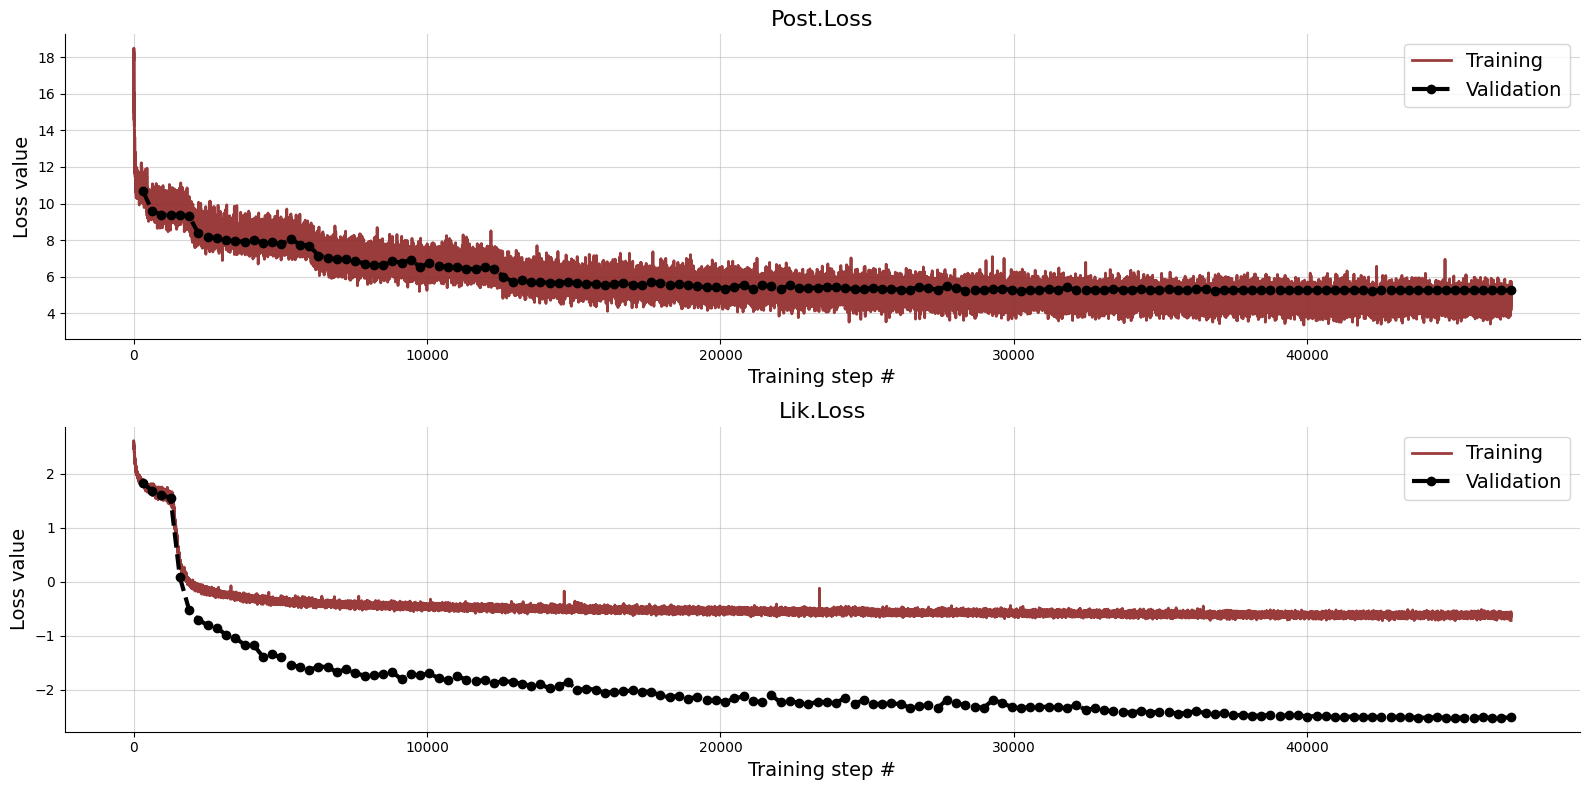

In [7]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])

## Test (Held-Out) Data

In [8]:
# Load test data
with open(f'test_data/{benchmark_name}_test.pkl', 'rb') as f:
    test_dict = pickle.load(f)

In [9]:
num_post_samples = 250

# Simulate from surrogate simulator
x_sim_s = amortizer.sample_data(test_dict, n_samples=100)[:, :, 0:1]
x_sim_s = np.abs(np.round(x_sim_s))

# Sample from posteriors given surrogate outputs
cond = test_dict['posterior_inputs']['summary_conditions'][:, :, 1:]
cond = np.concatenate([x_sim_s, cond], axis=-1)
post_samples_s = amortizer.sample_parameters({'summary_conditions': cond}, n_samples=num_post_samples)

# Sample from posteriors given simulator outputs
post_samples = amortizer.sample_parameters(test_dict, n_samples=num_post_samples)

# Prior samples
prior_samples = test_dict['posterior_inputs']['parameters']

### Calibration

#### ECDF Difference (Stacked)

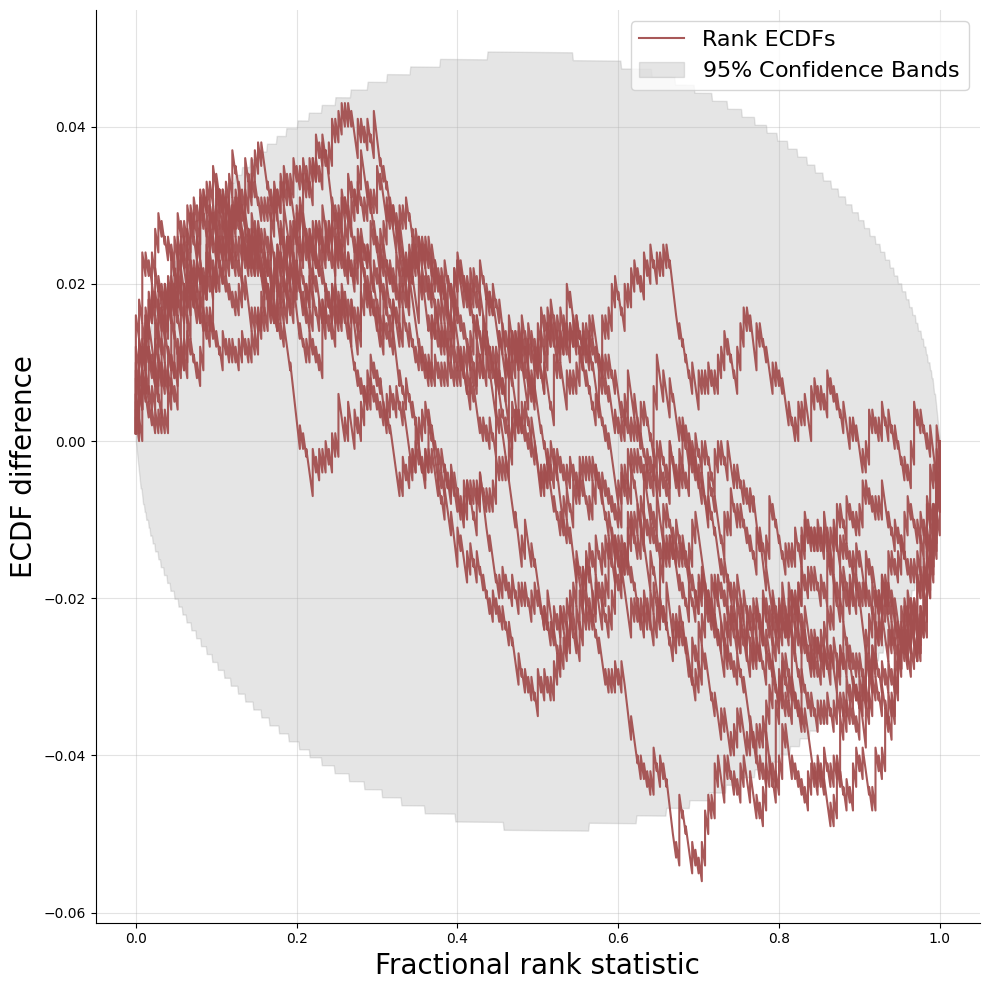

In [10]:
# Posterior given simulator outputs
f = plot_sbc_ecdf(post_samples, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), stacked=True,
                  fig_size=(10, 10), difference=True, label_fontsize=20, legend_fontsize=16)

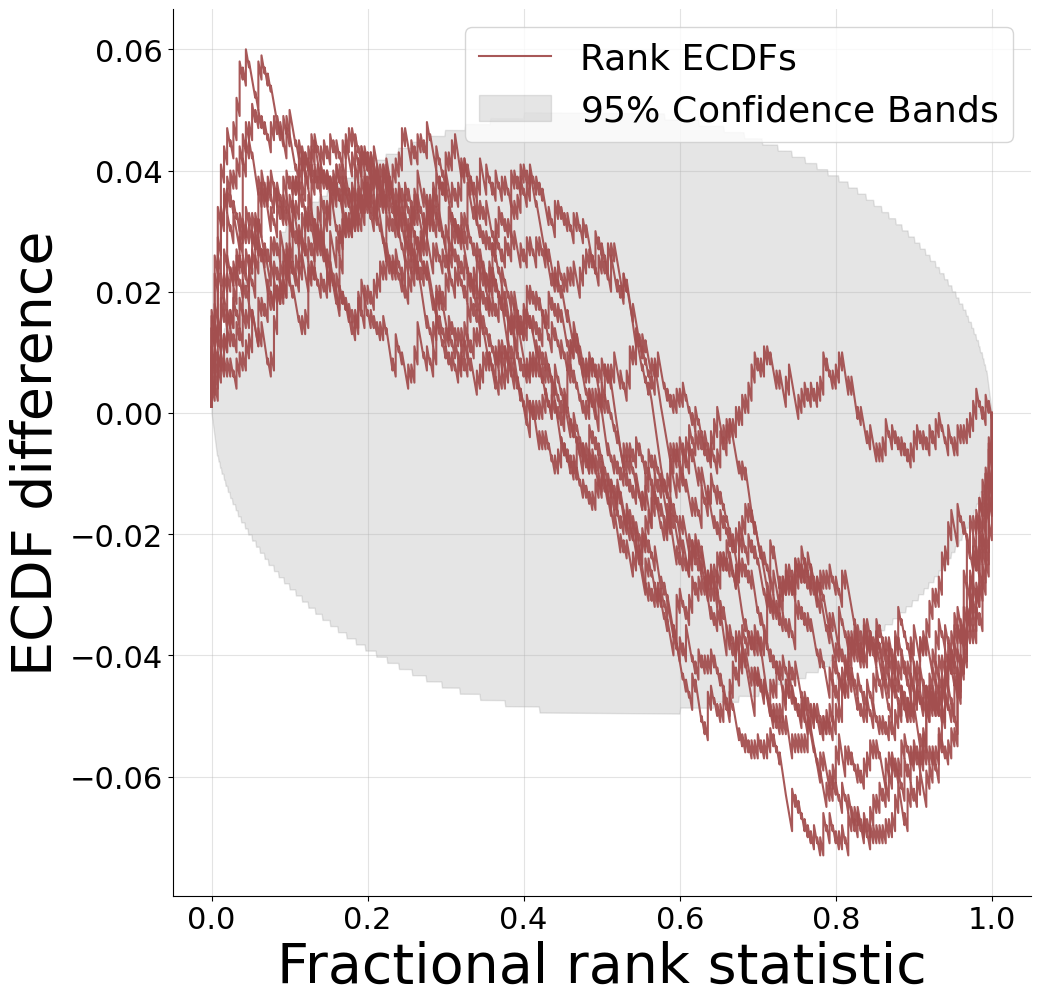

In [11]:
# Posterior given surrogate outputs
f = plot_sbc_ecdf(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), stacked=True,
                  difference=True, fig_size=(10, 10), label_fontsize=40, legend_fontsize=26)
_ = plt.xticks(fontsize=22)
_ = plt.yticks(fontsize=22)
f.savefig(f'figures/calibration/{benchmark_name}_diff.pdf', dpi=300, bbox_inches='tight')

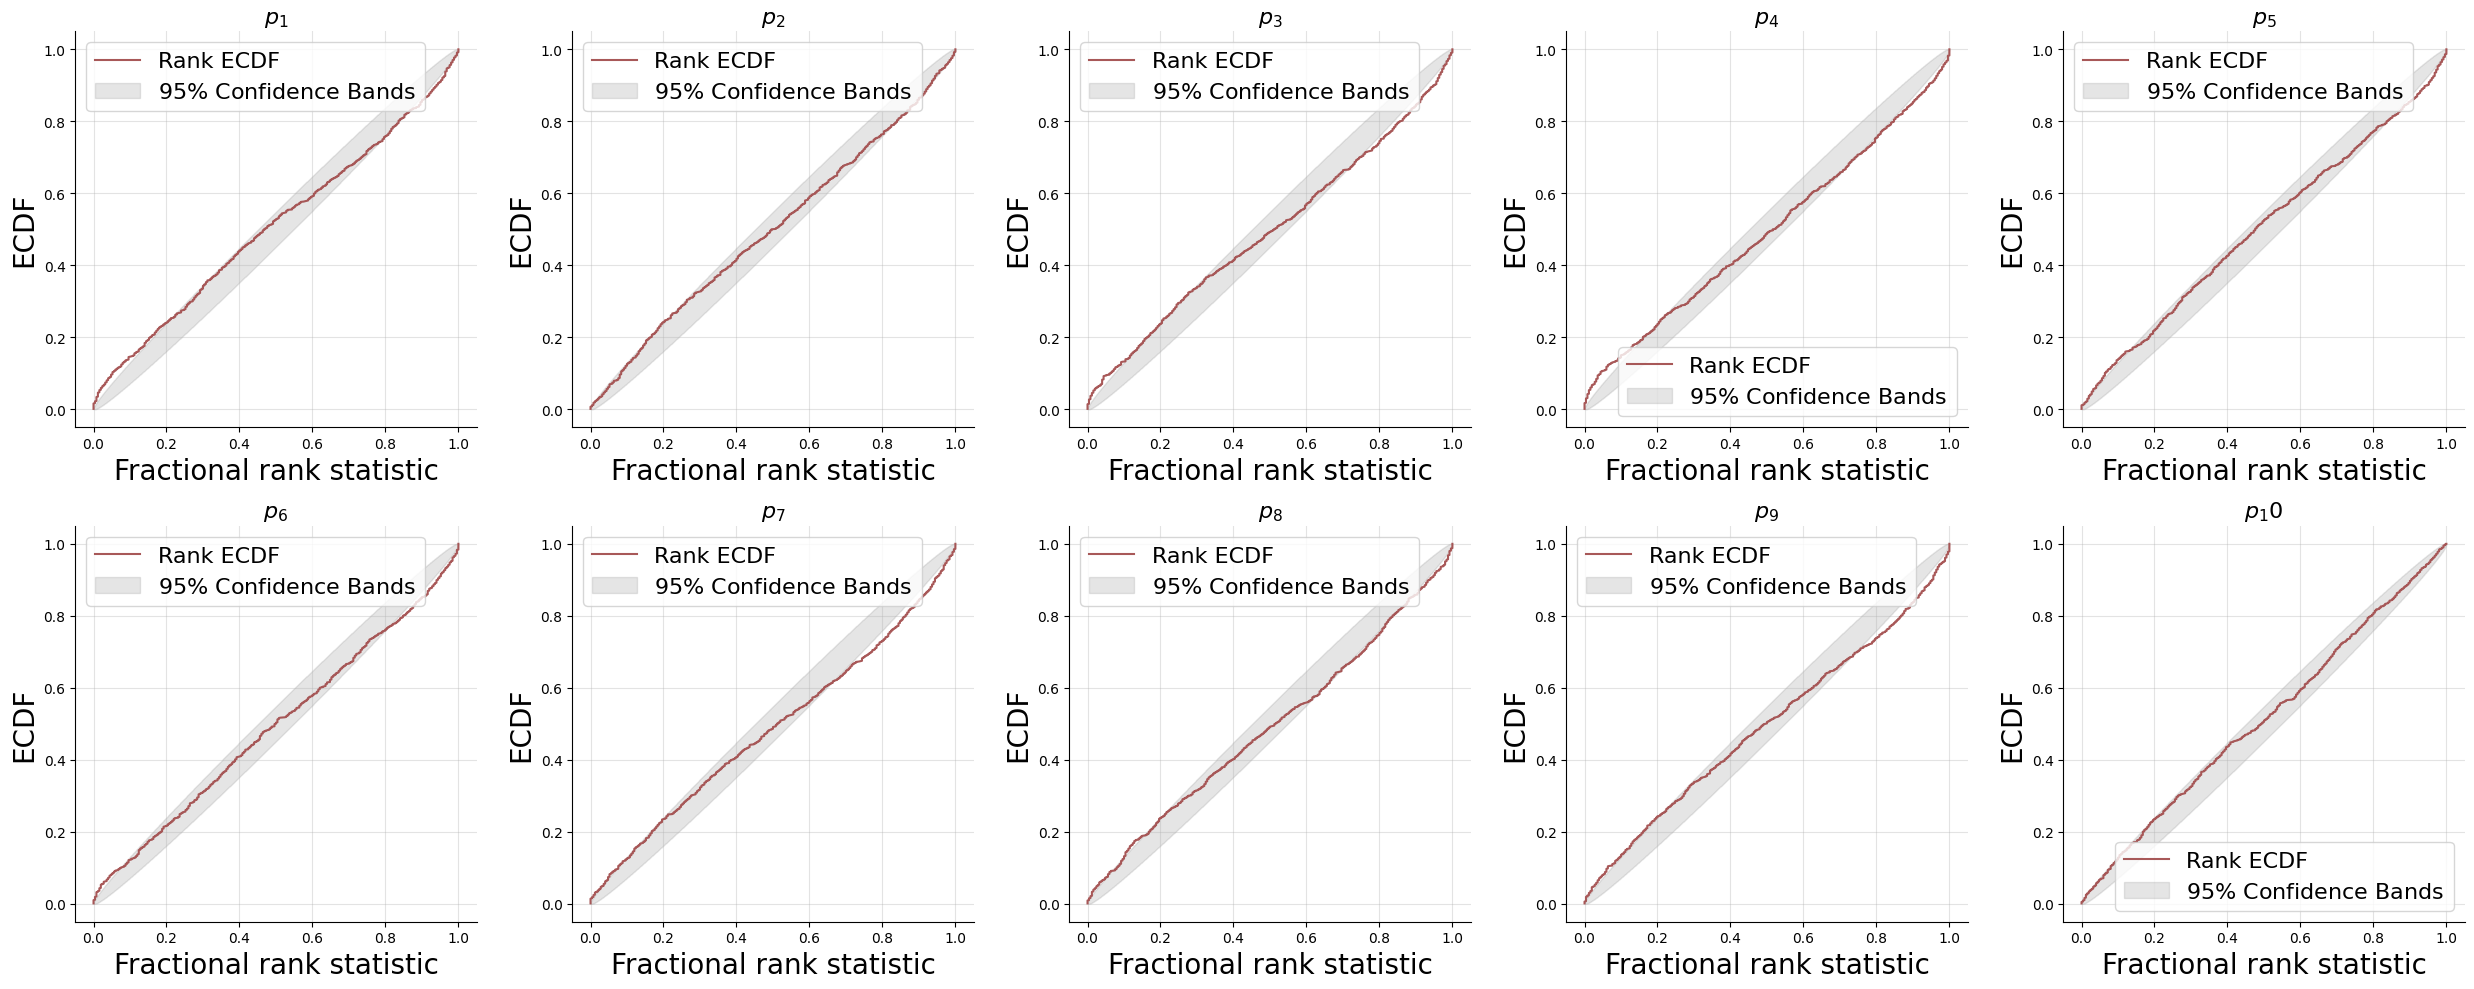

In [12]:
f = plot_sbc_ecdf(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), 
                  label_fontsize=20, legend_fontsize=16)

#### Recovery

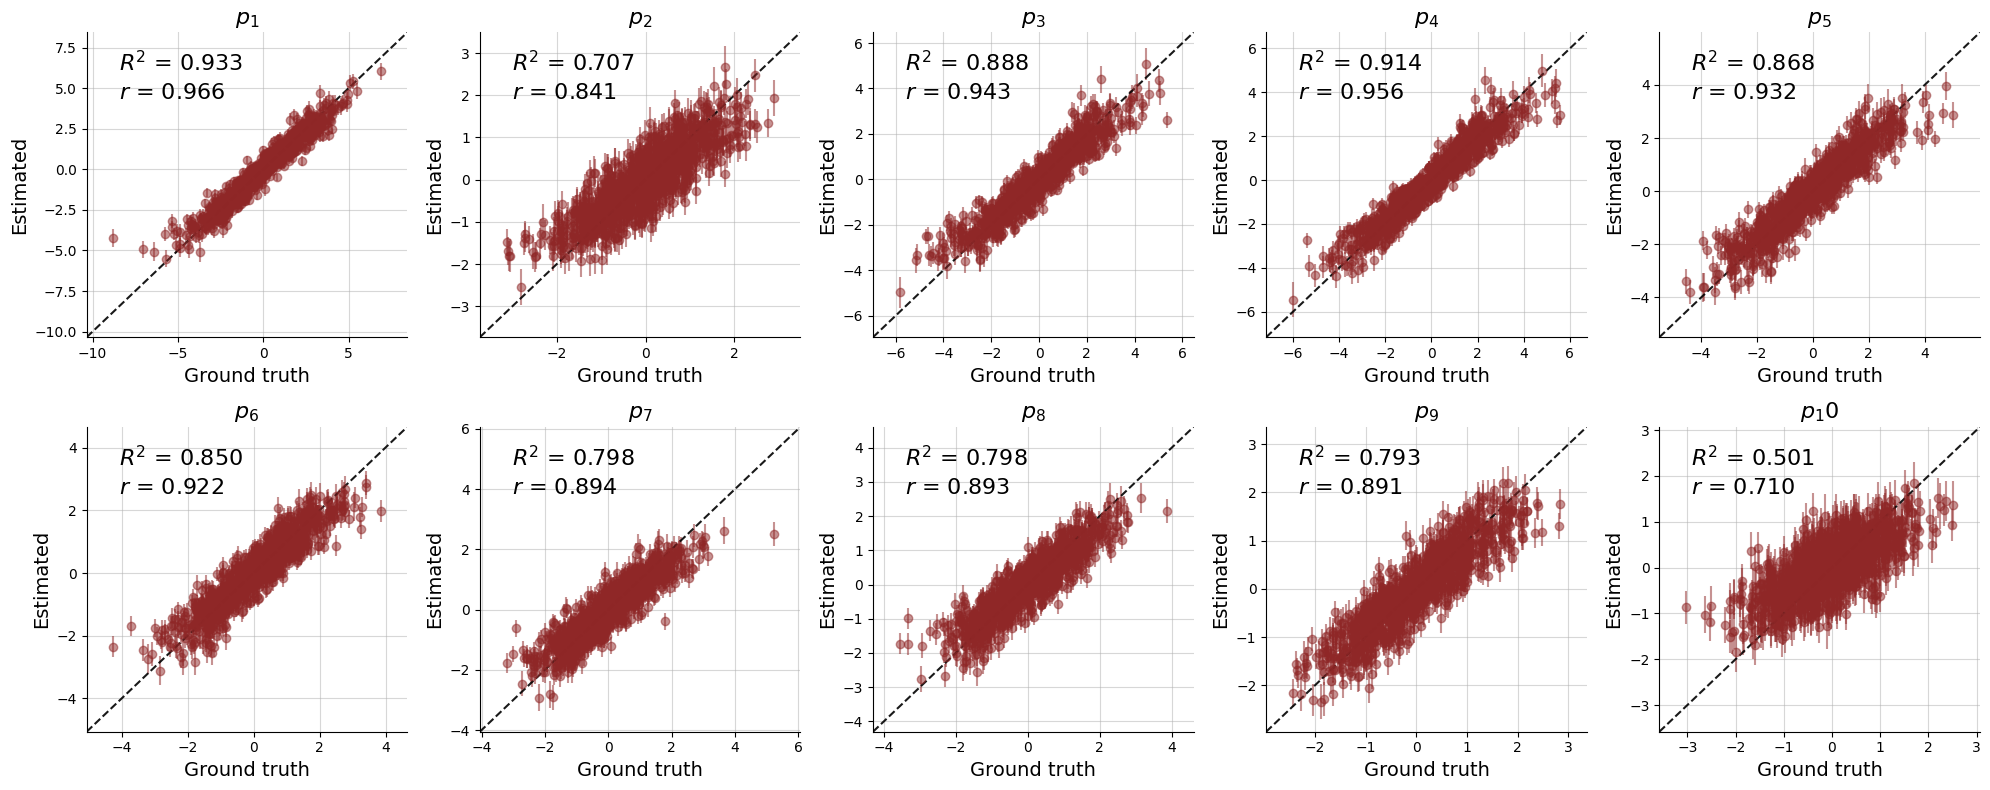

In [13]:
f = plot_recovery(post_samples, prior_samples)

# Appendix Plots

In [14]:
# load custom tighter plotting function
from custom_plots import plot_sbc_ecdf_appendix

# adjust for better readability
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

### Loss History

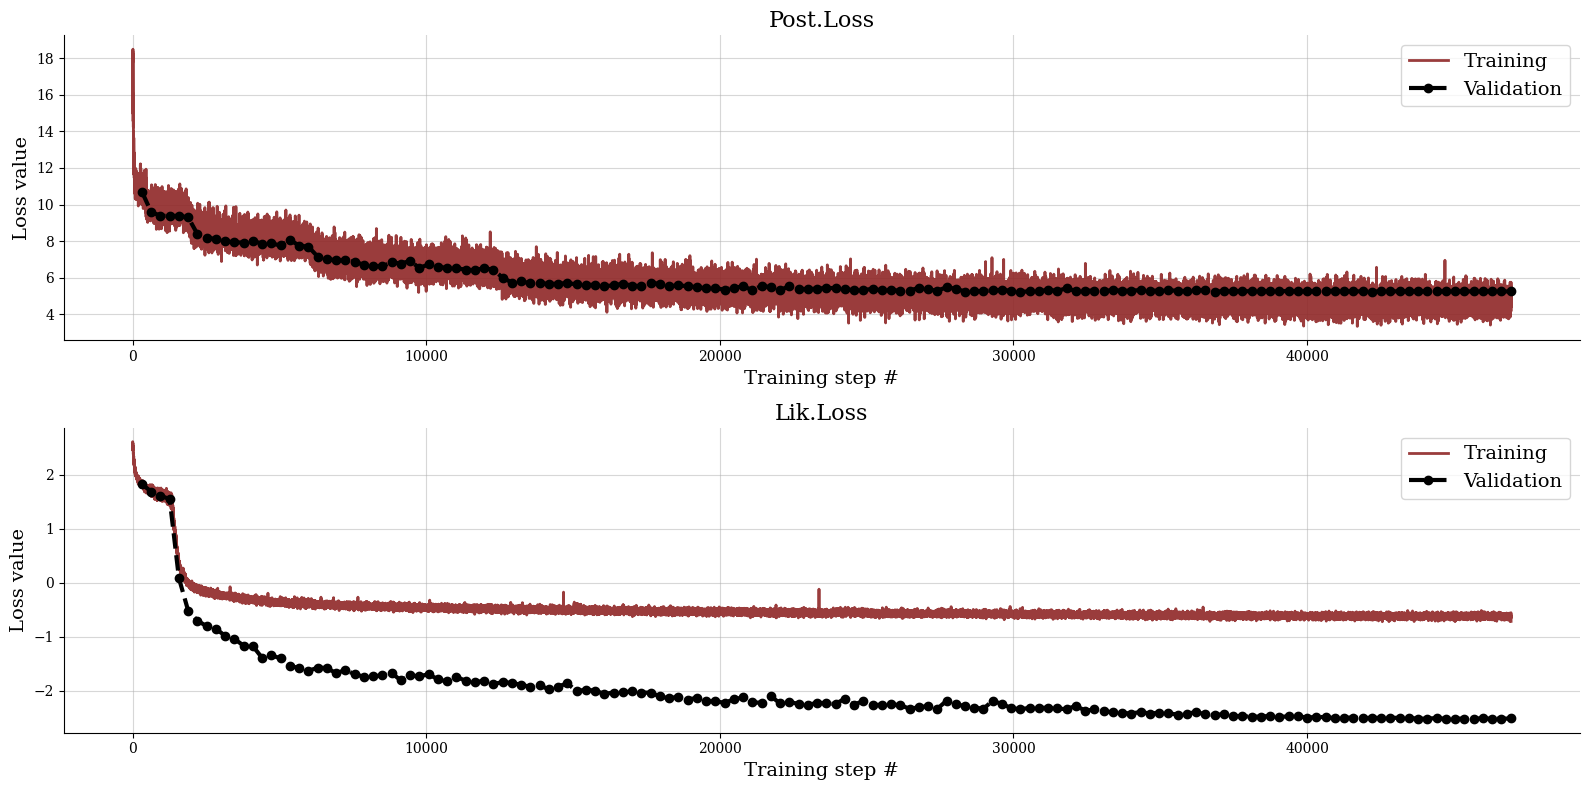

In [15]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])
plt.savefig(f"figures/{benchmark_name}_losses.pdf", dpi=300, bbox_inches="tight")

### Posterior Calibration

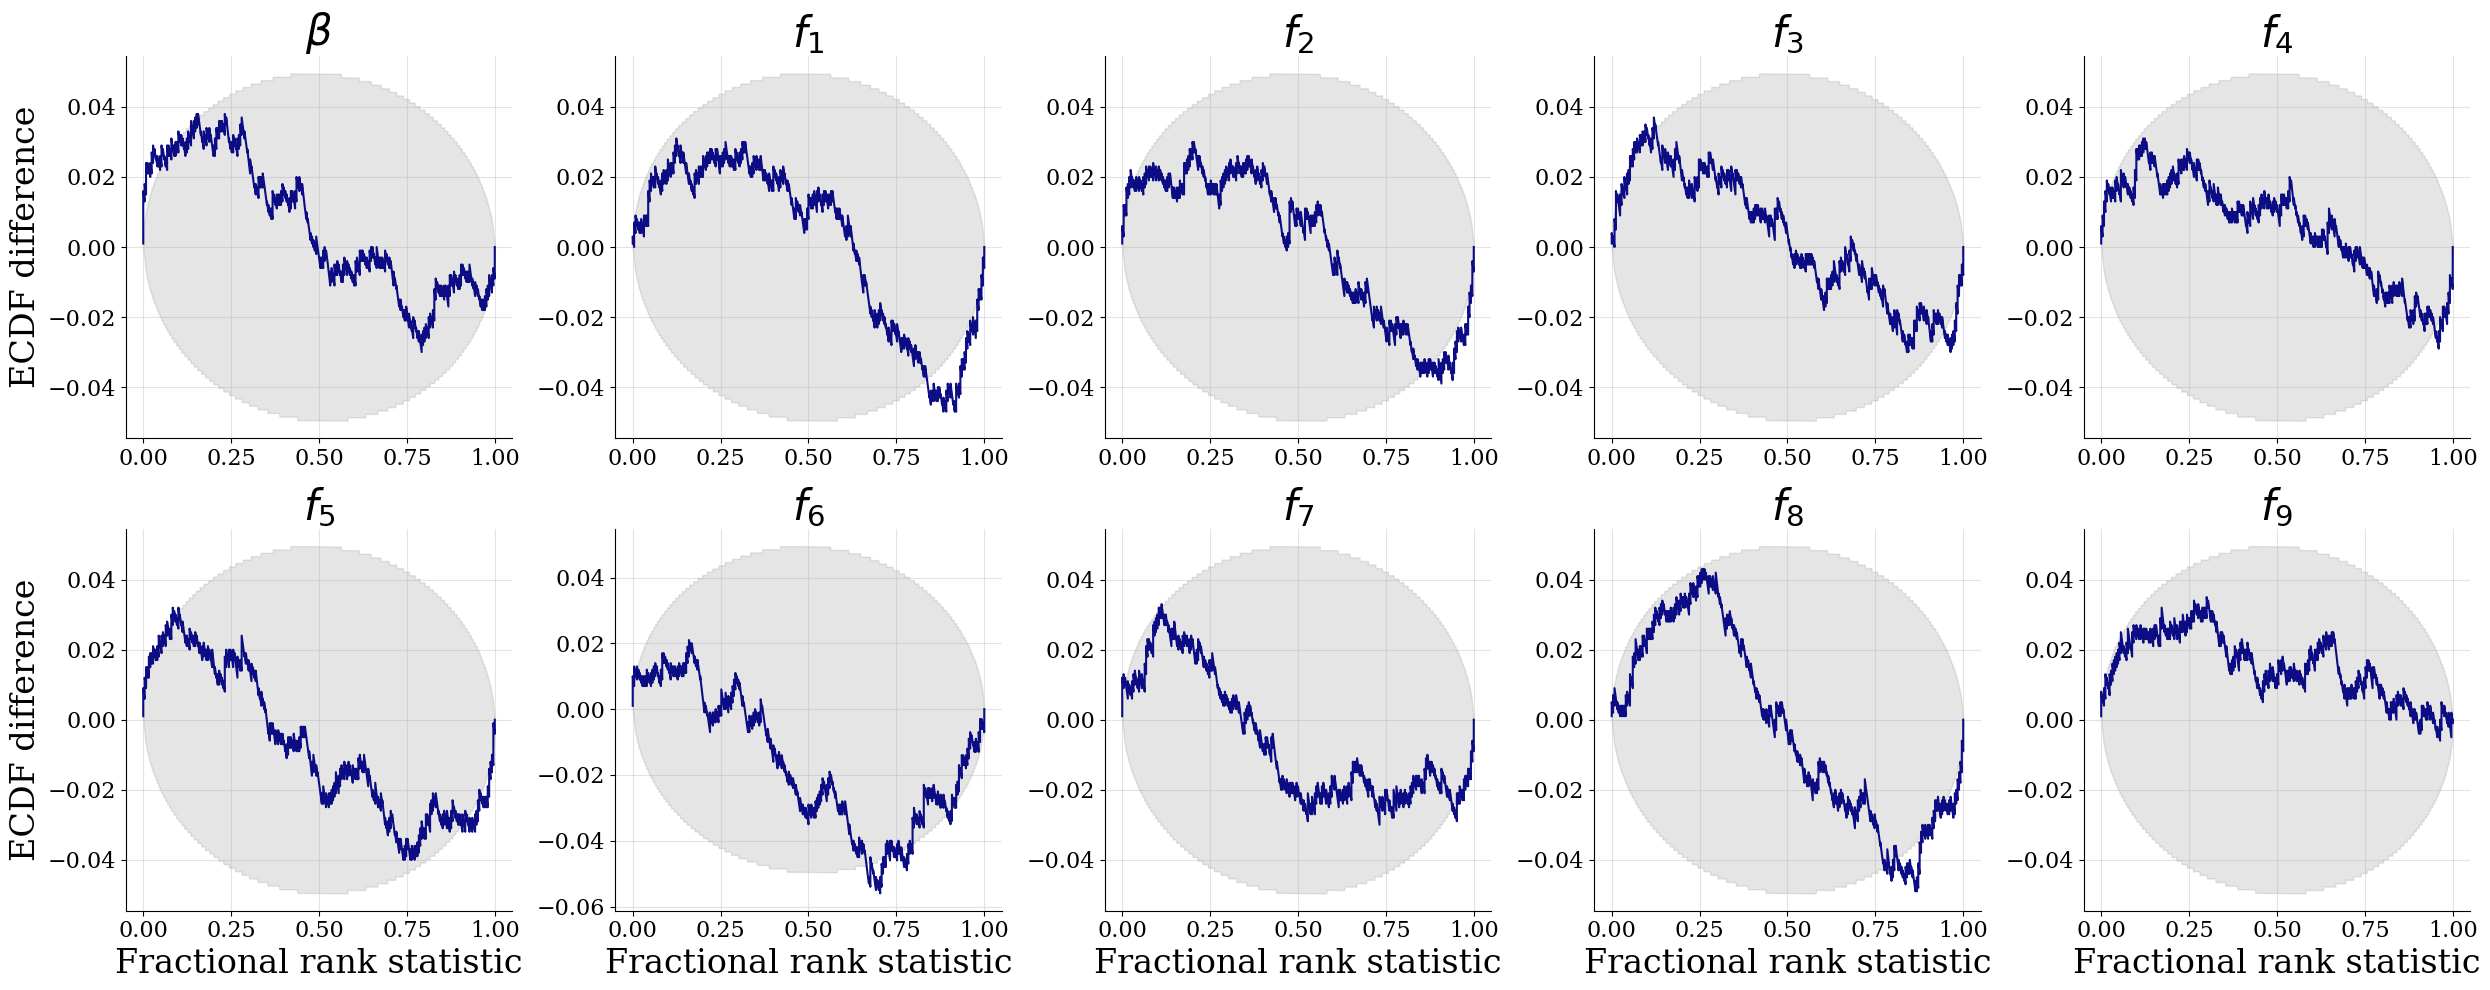

In [16]:
f = plot_sbc_ecdf_appendix(post_samples, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), 
                           param_names = benchmark.benchmark_info['parameter_names'],
                           label_fontsize=24, legend_fontsize=24, difference=True, rank_ecdf_color = '#000080' )
plt.savefig(f"figures/{benchmark_name}_posterior_calibration_diff_separate.pdf", dpi = 300, bbox_inches = "tight")

### Joint Calibration

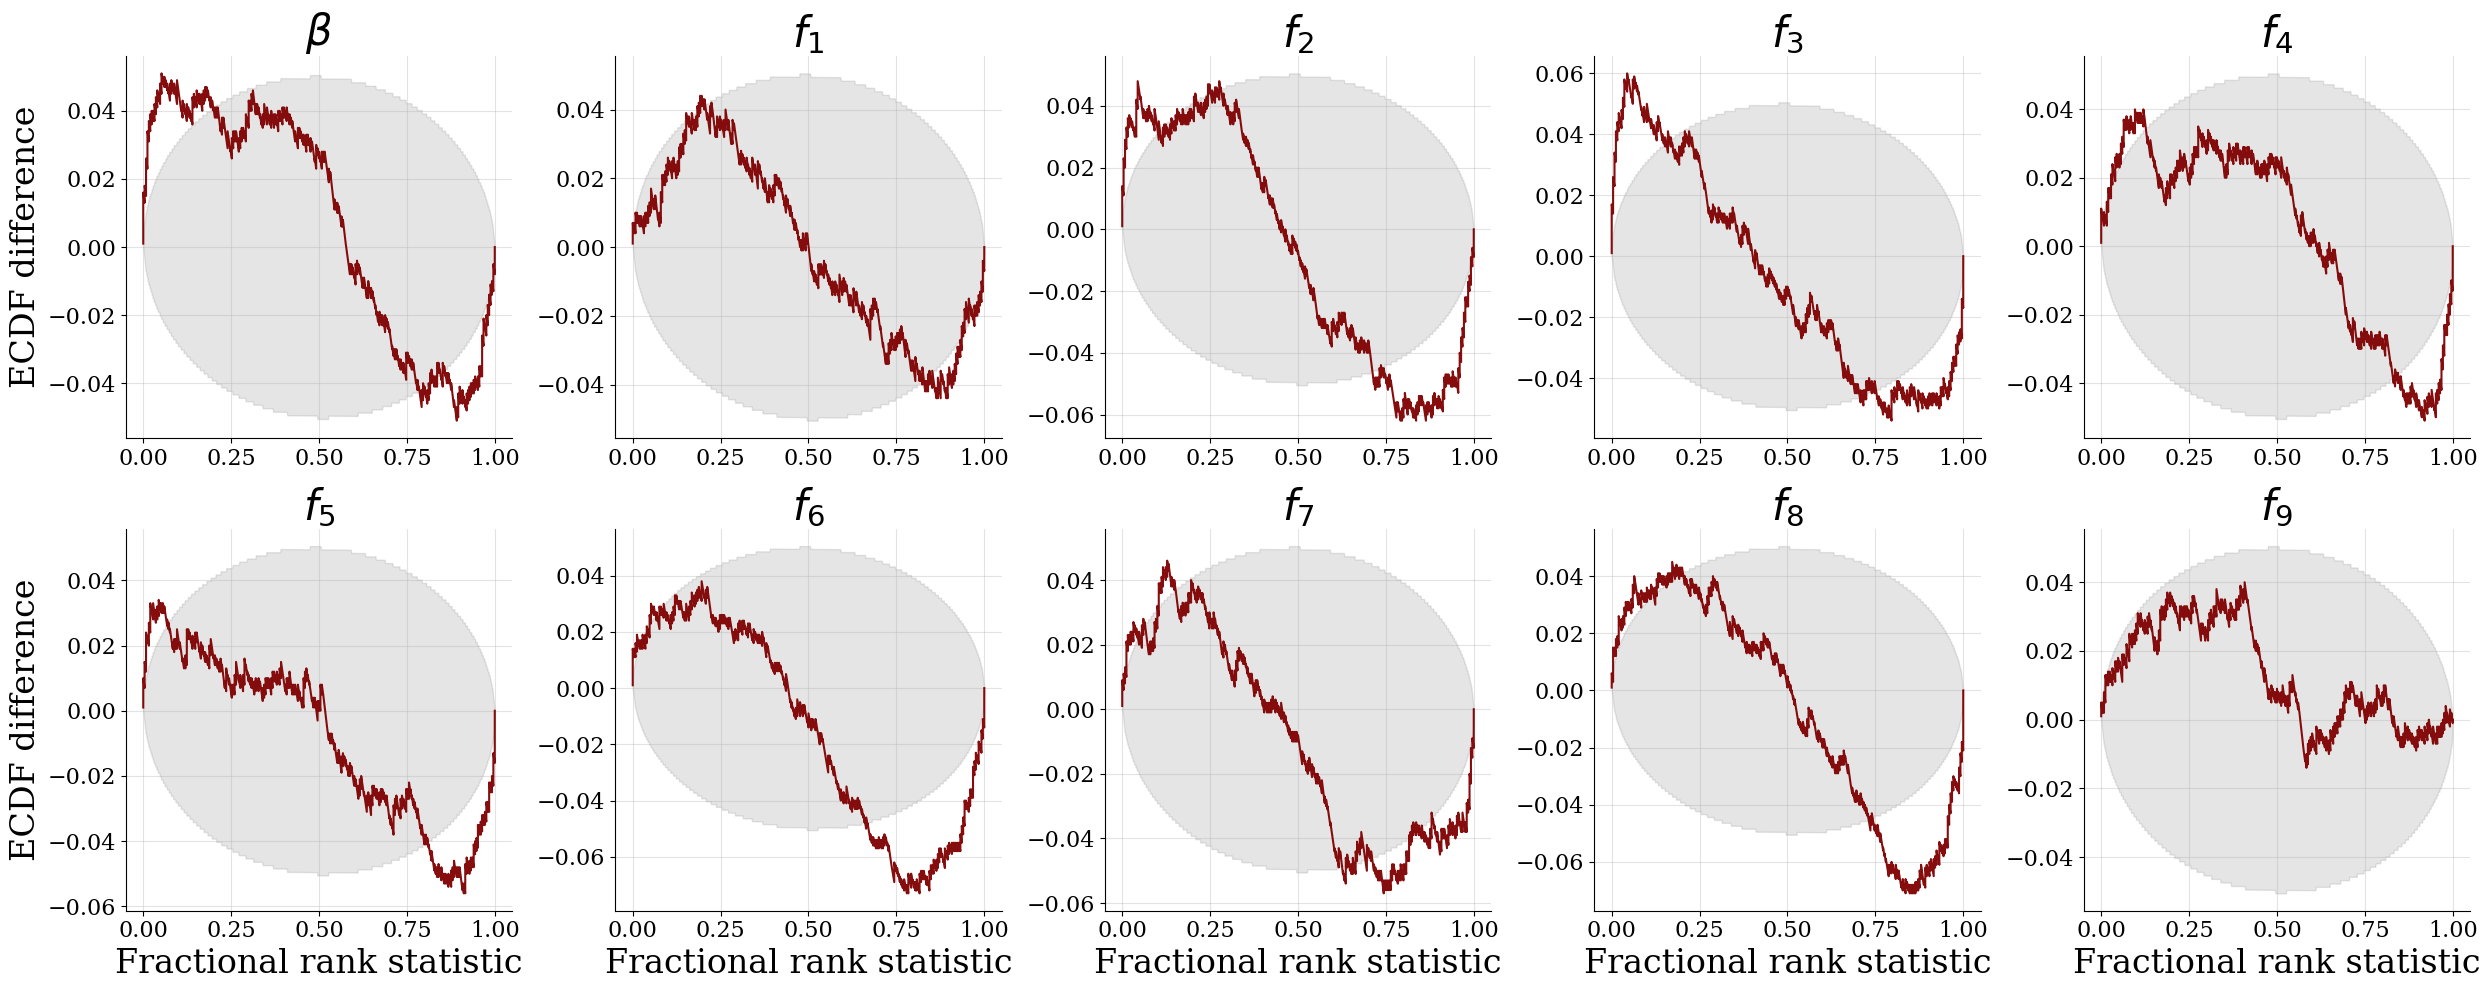

In [17]:
f = plot_sbc_ecdf_appendix(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), 
                           param_names = benchmark.benchmark_info['parameter_names'],
                           label_fontsize=24, legend_fontsize=24, difference=True, rank_ecdf_color = '#800000')
plt.savefig(f"figures/{benchmark_name}_joint_calibration_diff_separate.pdf", dpi = 300, bbox_inches = "tight")